Use Kedro with IPython and Jupyter Notebooks/Lab    

https://kedro.readthedocs.io/en/latest/11_tools_integration/02_ipython.html     

https://kedro.readthedocs.io/en/stable/12_faq/01_faq.html#what-is-data-engineering-convention    


In [1]:
import numpy as np
import pandas as pd

In [2]:
%reload_kedro

2021-03-28 12:57:44,917 - kedro.framework.session.store - INFO - `read()` not implemented for `BaseSessionStore`. Assuming empty store.
2021-03-28 12:57:45,013 - root - INFO - ** Kedro project xflats
2021-03-28 12:57:45,014 - root - INFO - Defined global variable `context`, `session` and `catalog`
2021-03-28 12:57:45,027 - root - INFO - Registered line magic `run_viz`


In [3]:
df = catalog.load('flatsjsonlines')

2021-03-28 12:57:45,044 - kedro.io.data_catalog - INFO - Loading data from `flatsjsonlines` (JSONLineDataSet)...


## Data preview

In [4]:
df.isna().sum() / df.shape[0]

2021-03-28 13:01:53,704 - numexpr.utils - INFO - NumExpr defaulting to 4 threads.


_id                      0.000000
tracking_id              0.000000
price                    0.000000
name                     0.000000
location                 0.000000
flat_size                0.000000
rooms                    0.006534
floor                    0.026751
producer_name            0.000000
price_m2                 0.000006
market                   0.000000
building_type            0.202891
description              0.000000
additional_info          0.000000
number_of_floors         0.123674
building_material        0.525097
year_of_building         0.196665
property_form            0.359204
download_date            0.000000
download_date_utc        0.000000
offeror                  0.208168
date_created             0.223327
date_modified            0.111734
GC_latitude              0.000000
GC_longitude             0.000000
GC_boundingbox           0.000000
GC_addr_road             0.036633
GC_addr_neighbourhood    0.459632
GC_addr_suburb           0.001856
GC_addr_city  

In [5]:
df.head(1).T

,0
_id,oto_61355393_1520000
tracking_id,61355393
price,1520000
name,Nowe > Ekskluzywnie > Komfortowo!
location,"Warszawa, Wola, Wolska"
flat_size,108
rooms,4.0
floor,11.0
producer_name,otodom
price_m2,13953.0


## Data normalisation

In [6]:
market = lambda x: 'wtorny' if x.lower().startswith('w') else 'pierwotny'

In [7]:
df.market.apply(market)

0         pierwotny
1         pierwotny
2         pierwotny
3         pierwotny
4         pierwotny
            ...    
178303       wtorny
178304       wtorny
178305       wtorny
178306       wtorny
178307       wtorny
Name: market, Length: 178308, dtype: object

In [8]:
df.apply(lambda x: min(x['date_modified'], x['date_created'], x['download_date']).date(), axis=1)

0         2021-01-06
1         2021-01-06
2         2021-01-06
3         2021-01-06
4         2021-01-06
             ...    
178303    2020-05-17
178304    2020-05-17
178305    2020-05-17
178306    2020-05-17
178307    2020-05-17
Length: 178308, dtype: object

In [9]:
import re
from unidecode import unidecode

In [10]:
df.building_type.fillna('n/a').replace({'':'n/a'}).apply(lambda x: re.sub(r'\s+',' ', unidecode(x).lower())).value_counts()

blok                              78121
apartamentowiec                   38980
n/a                               37642
kamienica                         15841
apartamentowiec                    1823
blok                               1002
blok mieszkalny                     929
kamienica                           743
dom wolnostojacy                    633
dom wielorodzinny/szeregowiec       543
niski blok                          497
szeregowiec                         454
wiezowiec                           308
pozostale                           250
budynek wielorodzinny               102
budynek apartamentowy                82
nowe budownictwo                     45
loft                                 43
mieszkalno-biurowy                   31
apartamentowo-handlowy               29
plomba                               28
dom wielorodzinny                    22
dom                                  19
niski wielorodzinny                  15
wysoki blok                          14


In [11]:
def building_type(x):
    _tmp = unidecode(x[:200]).lower()
    if any([i in _tmp for i in ('blok','mieszkanie')]):
        return 'blok'
    elif any([i in _tmp for i in ('dom','szeregowiec', 'segment', 'blizniak', 'willa', 'rezydencja')]):
        return 'dom'
    elif any([i in _tmp for i in ('apartamentowiec', 'wiezowiec', 'loft')]):
        return 'apartamentowiec'
    elif any([i in _tmp for i in ('kamienica','historyczny')]):
        return 'kamienica'
    else:
        return 'n/a'

In [12]:
df.building_type.fillna('n/a').apply(building_type).value_counts()

blok               80563
apartamentowiec    41155
n/a                38277
kamienica          16599
dom                 1714
Name: building_type, dtype: int64

In [13]:
df.building_material.fillna('n/a').replace({'':'n/a'}).apply(lambda x: re.sub(r'\s+',' ', unidecode(x).lower())).value_counts().head(20)

n/a                 96738
cegla               43542
inne                13658
wielka plyta         6962
zelbet               3313
pustak               2569
plyta                2385
cegla                2029
rama h               1753
silikat              1413
beton                1292
beton komorkowy       486
mieszana              427
rama h                327
wielka plyta          296
zelbeton              132
pustak                102
techn. mieszana        87
zroznicowany           81
plyta                  74
Name: building_material, dtype: int64

In [14]:
def building_material(x):
    if 'cegla' in unidecode(x).lower():
        return 'cegla'
    elif 'plyta' in unidecode(x).lower():
        return 'plyta'
    elif 'zelbet' in unidecode(x).lower():
        return 'zelbet'
    elif 'pustak' in unidecode(x).lower():
        return 'pustak'
    elif 'rama' in unidecode(x).lower():
        return 'rama'
    elif 'silikat' in unidecode(x).lower():
        return 'silikat'
    elif 'beton' in unidecode(x).lower():
        return 'beton'
    else:
        return 'n/a'

In [15]:
df.building_material.fillna('n/a').apply(building_material).value_counts()

n/a        111408
cegla       45676
plyta        9722
zelbet       3454
pustak       2704
rama         2082
beton        1841
silikat      1421
Name: building_material, dtype: int64

In [16]:
df.property_form.fillna('n/a').replace({'':'n/a'}).apply(lambda x: re.sub(r'\s+',' ', unidecode(x).lower())).value_counts().head(20)

n/a                                  66647
pelna wlasnosc                       65357
wlasnosc                             19845
spoldzielcze wlasnosciowe            11956
spoldzielcze wl. z kw                 7069
wlasnosc                              3542
spoldzielcze wlasnosciowe z kw        2609
spoldzielcze wlasnosciowe              363
spoldzielcze wlasnosciowe z kw         215
udzial                                 185
odrebna wlasnosc lokalu                 70
hipoteczne                              67
umowa z developerem                     49
spoldzielcze-wlasnosciowe               44
spoldzielcze wl. z kw                   34
spoldzielcze + kw                       33
spoldzielcza wlasnosciowa z kw          30
spoldzielcza wlasnosciowa bez kw        28
spol. wlasnosciowe                      24
spoldzielcze-wlasnosciowe z kw          24
Name: property_form, dtype: int64

In [17]:
def property_form(x):
    _tmp = re.sub(r'\s+',' ', unidecode(x).lower())
    if ('spol' in _tmp) and ('wl' in _tmp) and ('bez' in _tmp) and ('kw' in _tmp):
        return 'spol_wlasnosc'
    elif ('spol' in _tmp) and ('wl' in _tmp) and ('kw' in _tmp):
        return 'spol_wlasnosc_kw'
    elif ('spol' in _tmp) and ('wl' in _tmp):
        return 'spol_wlasnosc'
    elif ('spol' in _tmp) and ('kw' in _tmp):
        return 'spol_kw'
    elif ('wlasn' in _tmp):
        return 'wlasnosc'
    elif ('umowa' in _tmp) and ('develop' in _tmp):
        return 'umowa_z_developerem'
    elif ('hipo' in _tmp):
        return 'hipoteczne'
    elif ('udzial' in _tmp):
        return 'udzial'
    else:
        return 'n/a'

In [18]:
df.property_form.fillna('n/a').apply(property_form).value_counts()

wlasnosc               88823
n/a                    66699
spol_wlasnosc          12444
spol_wlasnosc_kw       10000
udzial                   191
hipoteczne                67
umowa_z_developerem       49
spol_kw                   35
Name: property_form, dtype: int64

In [19]:
df.offeror.fillna('n/a').replace({'':'n/a'}).apply(lambda x: re.sub(r'\s+',' ', unidecode(x).lower())).value_counts().head(20)

oferta biura nieruchomosci          77509
n/a                                 37118
oferta prywatna                     26227
osoby prywatnej                     10423
agencja                              6765
oferta dewelopera                    2788
biuro / deweloper                    2260
investor nieruchomosci franchise     1330
platan house                          915
oferta posrednika                     824
lloyd properties                      808
biuro sprzedazy                       561
eteria consulting sp. z o.o.          488
nieruchomosci chlebowski              464
tur nieruchomosci                     281
sokratesa development                 265
westa home                            257
en casa premium real estate           249
prywatny                              239
deweloper                             232
Name: offeror, dtype: int64

In [20]:
def offeror(x):
    if 'pryw' in unidecode(x).lower():
        return 'prywatna'
    if 'dew' in unidecode(x).lower():
        return 'deweloper'
    if 'dev' in unidecode(x).lower():
        return 'deweloper'
    else:
        return 'agencja'


In [21]:
df.offeror.fillna('n/a').apply(offeror).value_counts()

agencja      135343
prywatna      36889
deweloper      6076
Name: offeror, dtype: int64

### District

In [73]:
_locations = df.query("GC_addr_city=='Warszawa'").location.apply(lambda x: unidecode(x)).apply(lambda x: x[:])

In [74]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='word', min_df=0.001, ngram_range=(1,1))
X = vectorizer.fit_transform(_locations)

In [75]:
print(vectorizer.get_feature_names())

['47', '49', 'adama', 'al', 'aleja', 'aleje', 'aleksandra', 'aluzyjna', 'antoniego', 'augusta', 'batalionow', 'beethovena', 'bemowo', 'berensona', 'bezposrednio', 'bialoleka', 'bielany', 'blisko', 'bokserska', 'branickiego', 'brodno', 'broniewskiego', 'bruzdowa', 'brzeziny', 'budki', 'centrum', 'chelmzynska', 'chlopskich', 'chomiczowka', 'chrzanow', 'cybernetyki', 'czyste', 'deweloperski', 'dolny', 'domaniewska', 'dzieci', 'edwarda', 'franciszka', 'gen', 'goclaw', 'goclawek', 'gor', 'gorce', 'gorczewska', 'gorny', 'grochow', 'grochowska', 'grodzisk', 'grodziskie', 'grojecka', 'grzybowska', 'herbu', 'ii', 'imielin', 'jana', 'jelonki', 'jerozolimskie', 'jerzego', 'jezioranskiego', 'jozefa', 'juliana', 'juliusza', 'kabaty', 'kamionek', 'karola', 'kasprzaka', 'katy', 'kazimierza', 'kepa', 'klobucka', 'kolo', 'konstantego', 'ksawerow', 'leona', 'ludwika', 'marcina', 'marysin', 'mazowieckie', 'mehoffera', 'miasto', 'mieszkaniowy', 'mikolaja', 'milosna', 'mirow', 'mlynow', 'mokotow', 'muranow

In [154]:
df.location.apply().sample(100, random_state=20).values

array(['Warszawa, Wilanów, ul. Oś Królewska', 'Warszawa, Wola',
       'Warszawa, Mazowieckie, Białołęka', 'Warszawa, Mokotów, Obrzeżna',
       'Warszawa, Żoliborz, Dygasińskiego', 'Warszawa, Wola, Odolany',
       'Warszawa, Mokotów, Dolny Mokotów', 'Warszawa, Wola, Młynów',
       'Warszawa, Ursynów, Mandarynki 6',
       'Warszawa, Ochota, Rakowiec, ul. Mariana Nowickiego', 'Warszawa,',
       'Warszawa, Praga-Północ, ul. Łochowska', 'Warszawa,',
       'Warszawa, Śródmieście, mazowieckie',
       'Warszawa, Wilanów, ul. Królowej Marysieńki',
       'Warszawa, Ursus, ul. Kazimierza Pużaka', 'Warszawa, Żoliborz',
       'Warszawa, Mazowieckie, Śródmieście',
       'Warszawa, Mokotów, ul. Domaniewska 34B',
       'Warszawa, Mokotów, Wyględów', 'Warszawa, Białołęka',
       'Warszawa, Mokotów, Górny Mokotów, Karola Chodkiewicza',
       'Warszawa, Ochota, mazowieckie', 'Warszawa, Mokotów',
       'Warszawa, Włochy, mazowieckie', 'Warszawa,',
       'Warszawa, Ursus, Skorosze, Ryżowa',

In [208]:
df.GC_addr_suburb.value_counts() 

Mokotów           24584
Wola              23238
Śródmieście       20572
Białołęka         17324
Praga-Południe    14239
Ursynów            9777
Bemowo             9061
Bielany            7760
Ursus              7281
Ochota             6636
Targówek           6306
Wilanów            5969
Włochy             4912
Praga-Północ       4675
Warszawa           4399
Żoliborz           4190
Wawer              3330
Sielce             1548
Rembertów          1139
Wesoła              725
Natolin             287
Imielin              13
Kabaty                8
Wolica                1
Łódź-Polesie          1
Czyżyny               1
Krowodrza             1
Name: GC_addr_suburb, dtype: int64

In [143]:
import re

df['District'] = df.location.apply(lambda x: unidecode(x).lower())
df['District'] = df.District.apply(lambda x: re.split(", +", x)[1] if len(re.split(", +", x)) > 1 else 'n/a')
tmp_loc = pd.DataFrame(df['District'].value_counts()).query("District > 1000").index.values
tmp_loc = [i for i in tmp_loc if i not in ('n/a', 'mazowieckie')]

_district_GC = df.GC_addr_suburb.fillna('').apply(lambda x: unidecode(x).lower())

In [158]:
sorted(tmp_loc)

['bemowo',
 'bialoleka',
 'bielany',
 'mokotow',
 'ochota',
 'praga-polnoc',
 'praga-poludnie',
 'rembertow',
 'srodmiescie',
 'targowek',
 'ursus',
 'ursynow',
 'wawer',
 'wilanow',
 'wlochy',
 'wola',
 'zoliborz']

In [145]:
df['District'] = df['District'].apply(lambda x: x if x in tmp_loc else np.nan)

In [206]:
df[['District','GC_addr_suburb']].fillna("").apply(lambda x: x.apply(lambda z: unidecode(z).lower())).assign(cnt=1). \
    groupby(['District','GC_addr_suburb']).count().reset_index(). \
    pivot_table(values='cnt', index='GC_addr_suburb', columns='District',aggfunc=sum). \
    style.format("{:,.0f}").background_gradient(cmap='coolwarm')

District,,bemowo,bialoleka,bielany,mokotow,ochota,praga-polnoc,praga-poludnie,rembertow,srodmiescie,targowek,ursus,ursynow,wawer,wilanow,wlochy,wola,zoliborz
GC_addr_suburb,,,,,,,,,,,,,,,,,,
,14,nan,nan,52,30,46,nan,3,8,8,nan,86,30,20,12,19,1,2
bemowo,"1,594","7,327",2,15,3,nan,nan,nan,1,6,4,11,nan,nan,nan,10,86,2
bialoleka,"2,470",2,"14,781",4,25,2,5,nan,nan,2,29,nan,nan,1,nan,1,nan,2
bielany,"1,339",28,9,"6,077",nan,nan,nan,1,nan,nan,1,nan,nan,4,nan,nan,1,300
czyzyny,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
imielin,3,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,10,nan,nan,nan,nan,nan
kabaty,2,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,6,nan,nan,nan,nan,nan
krowodrza,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
lodz-polesie,1,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


GC_addr_suburb is enaught accurate, no need to complicate feature engineering. 

### code

In [22]:
import re
from unidecode import unidecode
import numpy as np
import pandas as pd

def market(x):
    if x.lower().startswith('w'):
        return 'wtorny'  
    else:
        return'pierwotny'

def building_type(x):
    _tmp = unidecode(x).lower()
    if any([i in _tmp for i in ('blok','mieszkanie')]):
        return 'blok'
    elif any([i in _tmp for i in ('dom','szeregowiec', 'segment', 'blizniak', 'willa', 'rezydencja')]):
        return 'dom'
    elif any([i in _tmp for i in ('apartamentowiec', 'wiezowiec', 'loft')]):
        return 'apartamentowiec'
    elif any([i in _tmp for i in ('kamienica','historyczny')]):
        return 'kamienica'
    else:
        return 'n/a'

    
def building_material(x):
    _tmp = unidecode(x).lower()
    if 'cegla' in _tmp:
        return 'cegla'
    elif 'plyta' in _tmp:
        return 'plyta'
    elif 'zelbet' in _tmp:
        return 'zelbet'
    elif 'pustak' in _tmp:
        return 'pustak'
    elif 'rama' in _tmp:
        return 'rama'
    elif 'silikat' in _tmp:
        return 'silikat'
    elif 'beton' in _tmp:
        return 'beton'
    else:
        return 'n/a'
    

def property_form(x):
    _tmp = re.sub(r'\s+',' ', unidecode(x).lower())
    if ('spol' in _tmp) and ('wl' in _tmp) and ('bez' in _tmp) and ('kw' in _tmp):
        return 'spol_wlasnosc'
    elif ('spol' in _tmp) and ('wl' in _tmp) and ('kw' in _tmp):
        return 'spol_wlasnosc_kw'
    elif ('spol' in _tmp) and ('wl' in _tmp):
        return 'spol_wlasnosc'
    elif ('spol' in _tmp) and ('kw' in _tmp):
        return 'spol_kw'
    elif ('wlasn' in _tmp):
        return 'wlasnosc'
    elif ('umowa' in _tmp) and ('develop' in _tmp):
        return 'umowa_z_developerem'
    elif ('hipo' in _tmp):
        return 'hipoteczne'
    elif ('udzial' in _tmp):
        return 'udzial'
    else:
        return 'n/a'
    

def offeror(x):
    _tmp = unidecode(x).lower()
    if 'pryw' in _tmp:
        return 'prywatna'
    if 'dew' in _tmp:
        return 'deweloper'
    if 'dev' in _tmp:
        return 'deweloper'
    else:
        return 'agencja'


def date_offer(*dates):
    return min(dates).date()


In [23]:
df.offeror = df.offeror.fillna('n/a').apply(offeror)
df.property_form = df.property_form.fillna('n/a').apply(property_form)
df.building_material = df.building_material.fillna('n/a').apply(building_material)
df.building_type = df.building_type.fillna('n/a').apply(building_type)
df.market = df.market.fillna('n/a').apply(market)

In [24]:
df['date_offer'] = df['date_modified'].combine_first(df['date_created']).combine_first(df['download_date'])

In [25]:
df.sample(5, random_state=666)

,_id,tracking_id,price,name,location,flat_size,rooms,floor,producer_name,price_m2,...,GC_addr_road,GC_addr_neighbourhood,GC_addr_suburb,GC_addr_city,GC_addr_state,GC_addr_postcode,GC_addr_country,GC_addr_country_code,prediction,date_offer
493,gra_18829827_470000,18829827,470000,Nowe mieszkanie Warszawa Szamoty,"Warszawa, Szamoty, mazowieckie",64,3.0,1.0,gratka,7343.0,...,None,None,Ursus,Warszawa,województwo mazowieckie,01-330,Polska,pl,NaN,2020-11-02 00:00:00
163089,mor_2035932783_490000,2035932783,490000,"Warszawa,","Warszawa,",37,2.0,3.0,morizon,13243.0,...,Aleja Wyścigowa,Służew,Mokotów,Warszawa,województwo mazowieckie,02-681,Polska,pl,NaN,2020-03-06 00:00:00
6559,olx_612638840_430000,612638840,430000,"StyLOVE & PRZESTRONNE ""pod klucz""z komórką/M3z...","Warszawa, Mazowieckie, Białołęka",53,3.0,1.0,olx,8113.0,...,Dionizosa,Nowodwory,Białołęka,Warszawa,województwo mazowieckie,03-189,Polska,pl,NaN,2020-06-22 00:00:00
170041,mor_2036168523_464000,2036168523,464000,"Warszawa,","Warszawa,",33,1.0,5.0,morizon,13984.0,...,Stanisława Worcella,Odolany,Wola,Warszawa,województwo mazowieckie,01-250,Polska,pl,NaN,2020-04-19 00:00:00
114631,oto_61576801_989000,61576801,989000,Retro Apartament w Kamienicy! Prywatna winda/t...,"Warszawa, Śródmieście",77,3.0,3.0,otodom,12761.0,...,Siedmiogrodzka,None,Wola,Warszawa,województwo mazowieckie,01-204,Polska,pl,NaN,2021-03-03 14:11:48


## One dimensional analysis

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from matplotlib.ticker import FuncFormatter


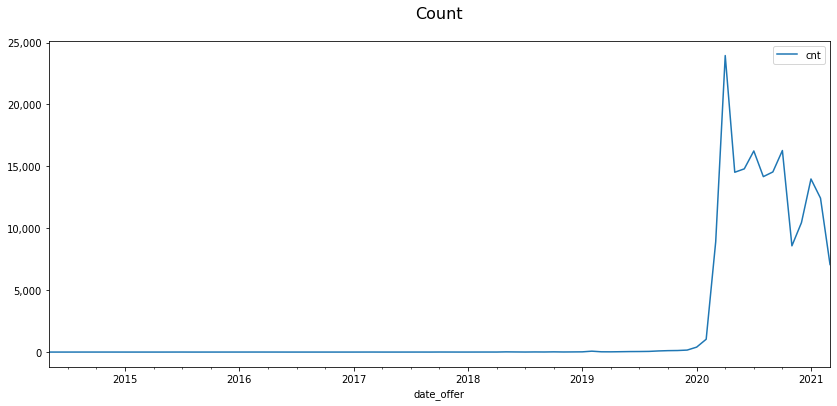

In [27]:
fig, ax = plt.subplots(figsize=(14,6))
_tmp = pd.DataFrame(
    {'date_offer':df.date_offer.dt.to_period("M"),
     'price':df.price})
_tmp.assign(cnt=1).groupby('date_offer').aggregate(cnt=('cnt','count')).plot(ax=ax)

plt.title('Count', y=1.05, fontsize = 16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y))) 


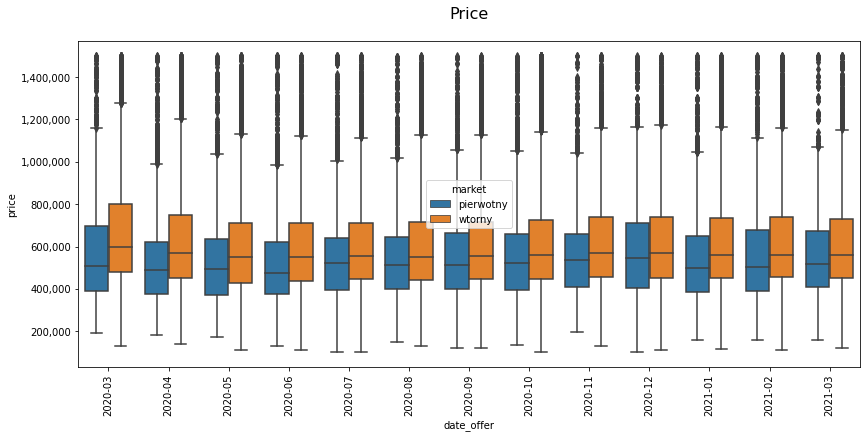

In [70]:
_tmp = pd.DataFrame(
    {'date_offer':df.date_offer.dt.to_period("M"),
     'market':df.market,
     'GC_addr_city':df.GC_addr_city,
     'price':df.price})
_tmp = _tmp.query("date_offer >= '2020-03' and price > 10e4 and price < 15e5 and GC_addr_city=='Warszawa'").reset_index()


fig, ax = plt.subplots(figsize=(14,6))
sns.boxplot(x="date_offer",  y="price",hue='market', data=_tmp, ax=ax, order=sorted(_tmp.date_offer.unique()))
plt.xticks(rotation=90)
plt.title('Price', y=1.05, fontsize = 16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y))) 
plt.show()

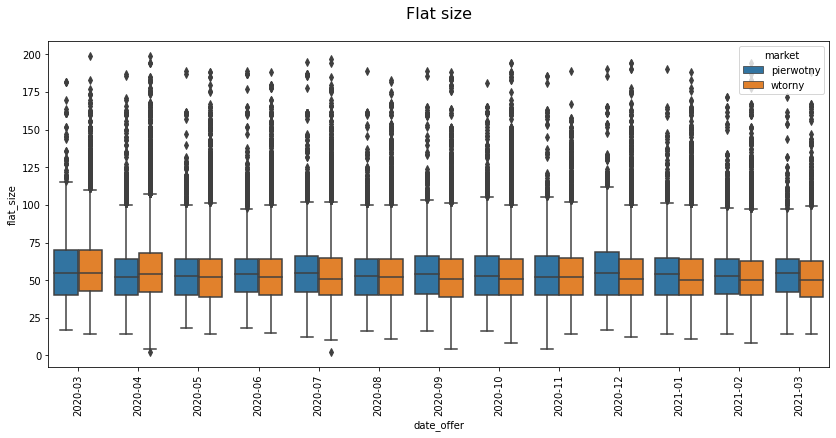

In [71]:
_tmp = pd.DataFrame(
    {'date_offer':df.date_offer.dt.to_period("M"),
     'price':df.price,
     'market':df.market,
     'GC_addr_city':df.GC_addr_city,
     'flat_size':df.flat_size})
_tmp = _tmp.query("date_offer >= '2020-03' and price > 10e4 and price < 15e5 and flat_size < 200 and GC_addr_city=='Warszawa'").reset_index()


fig, ax = plt.subplots(figsize=(14,6))
sns.boxplot(x="date_offer",  y="flat_size", hue='market', data=_tmp, ax=ax, order=sorted(_tmp.date_offer.unique()))
plt.xticks(rotation=90)
plt.title('Flat size', y=1.05, fontsize = 16)
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0f}'.format(y))) 
plt.show()

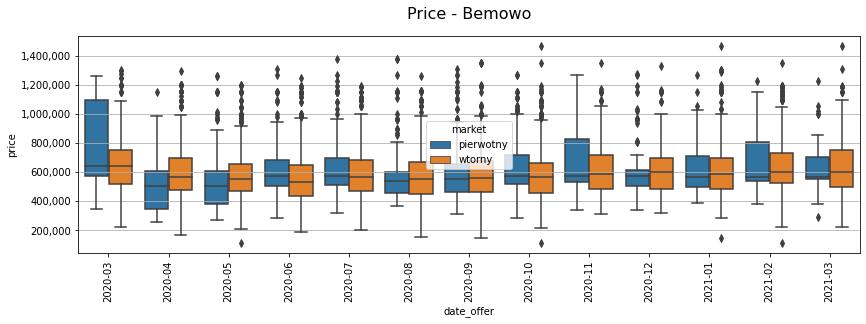

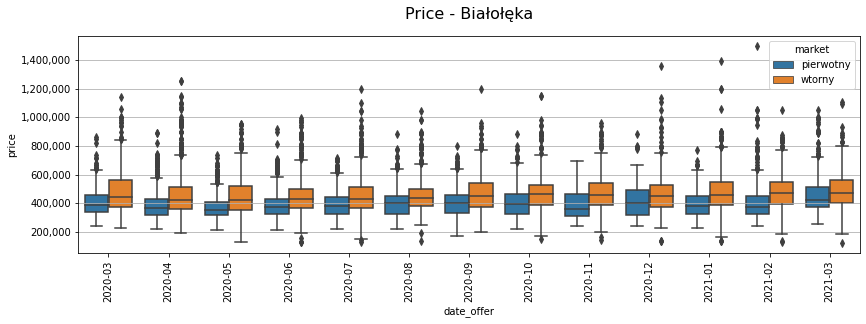

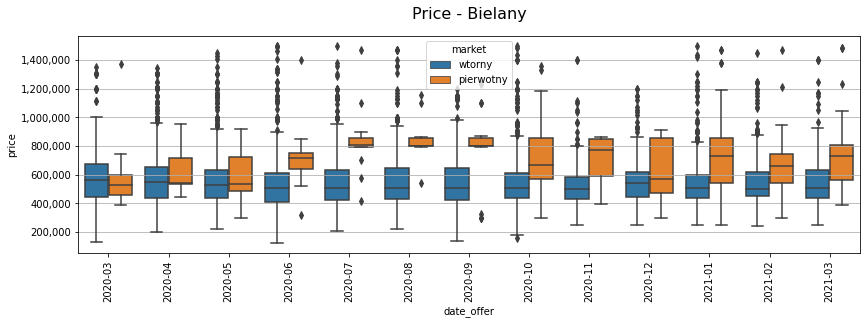

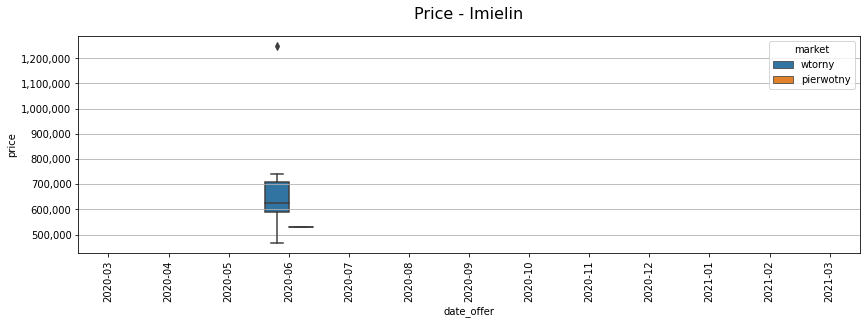

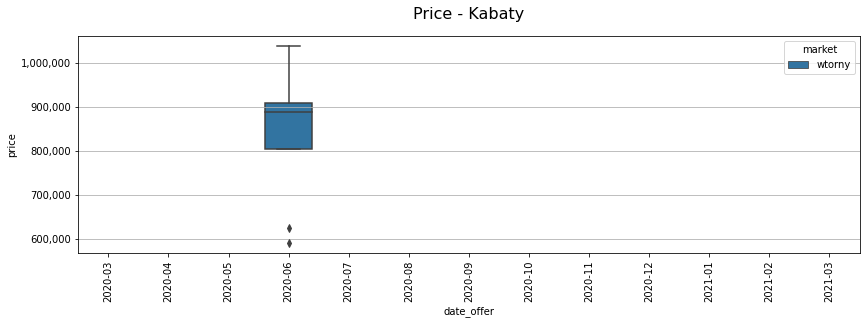

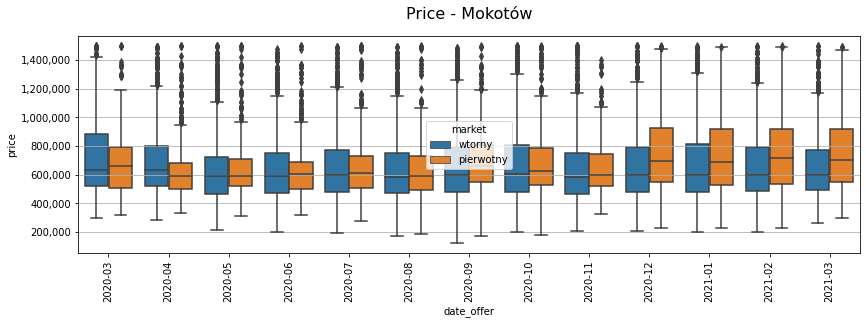

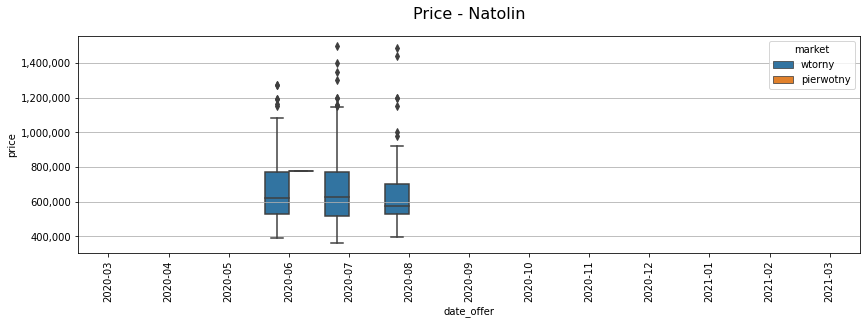

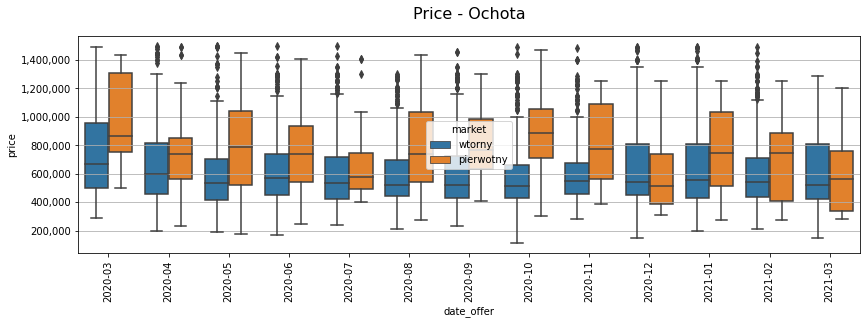

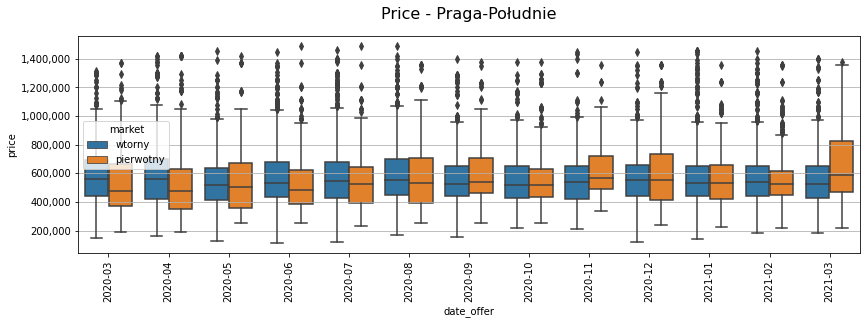

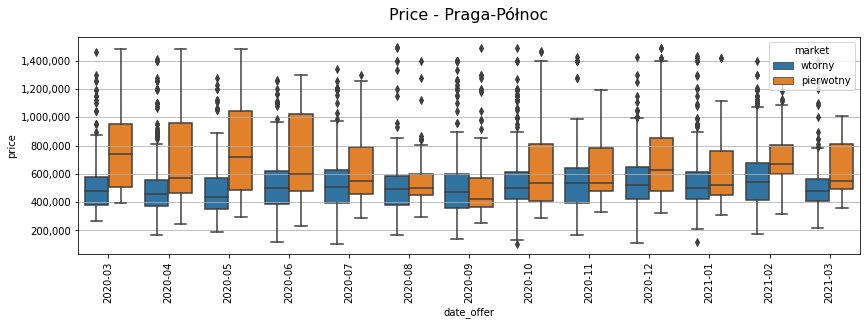

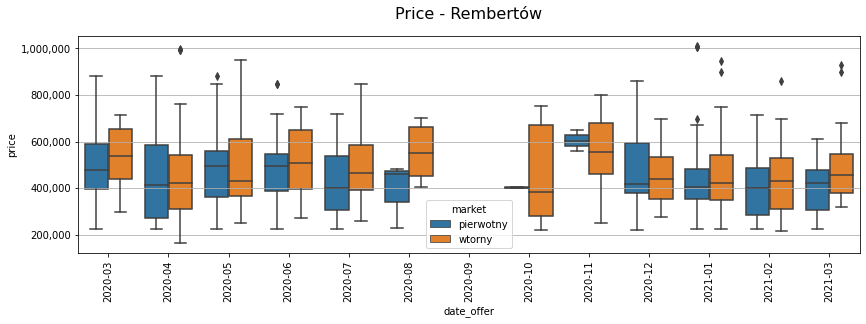

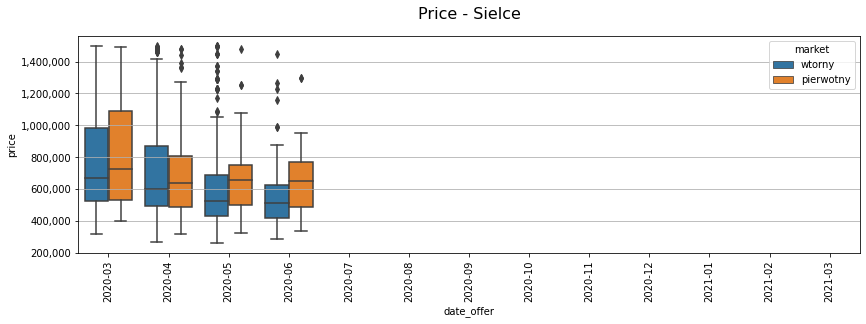

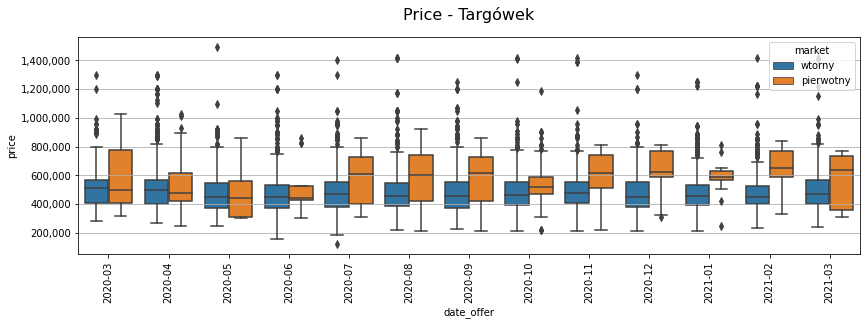

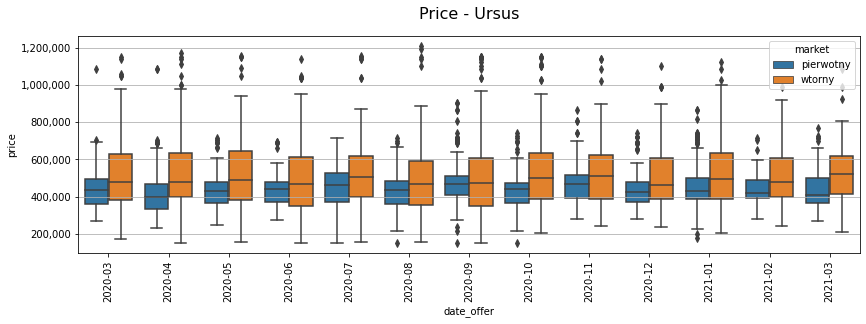

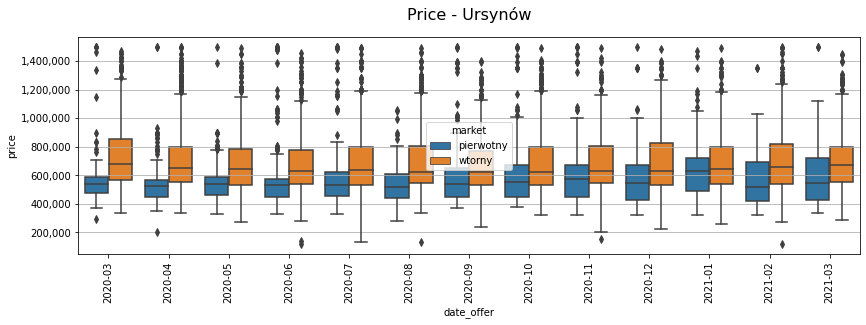

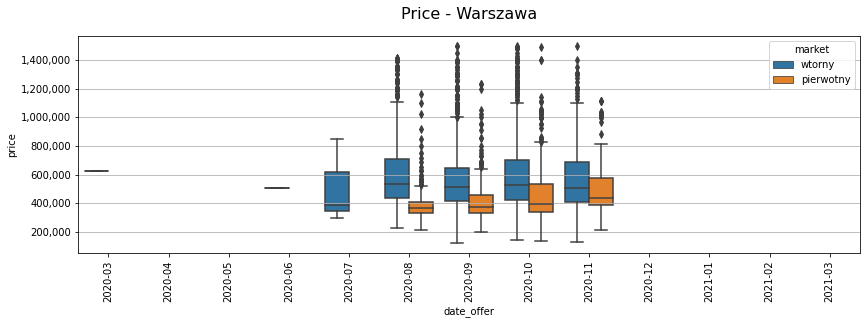

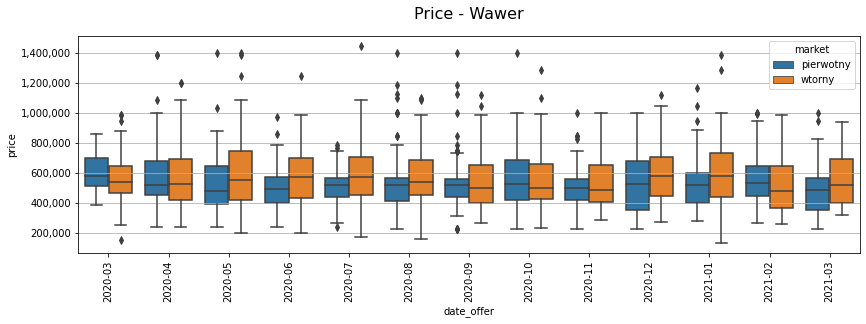

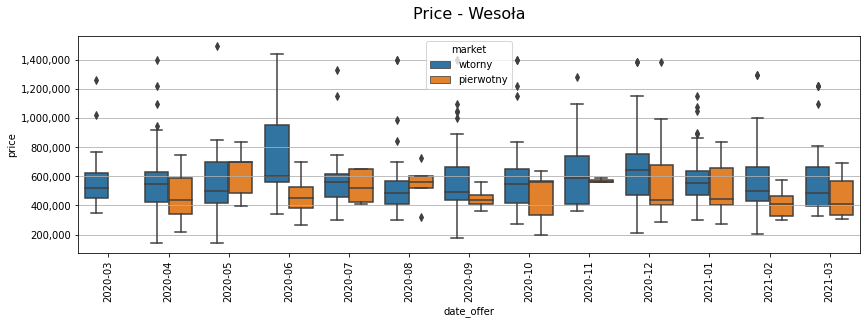

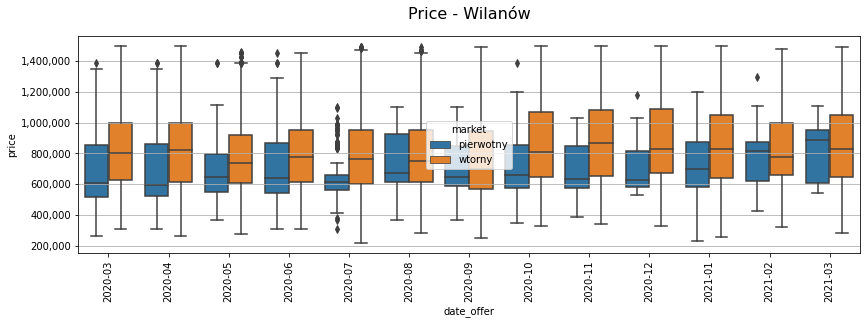

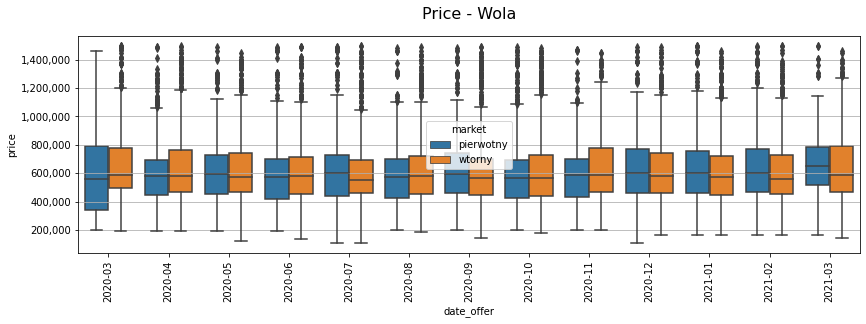

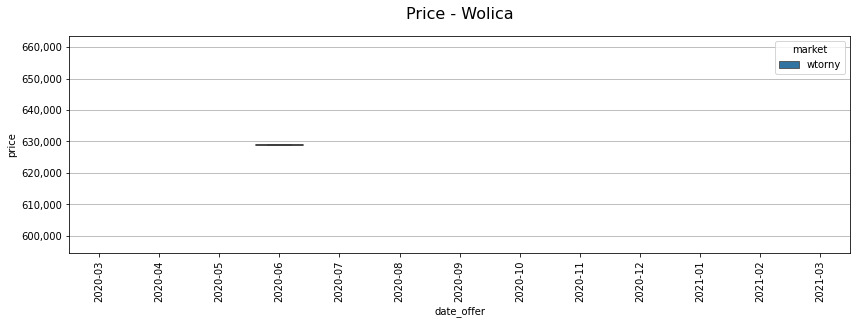

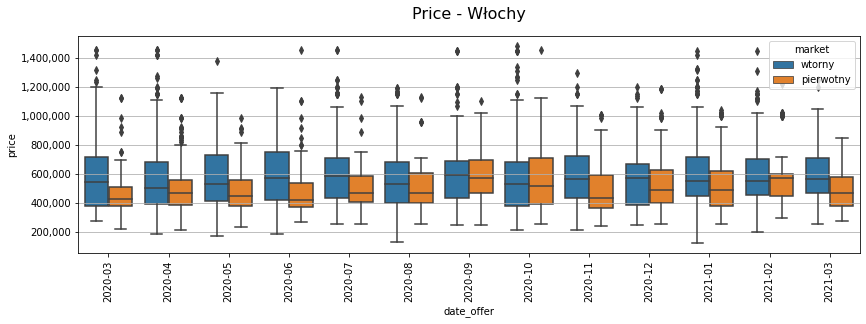

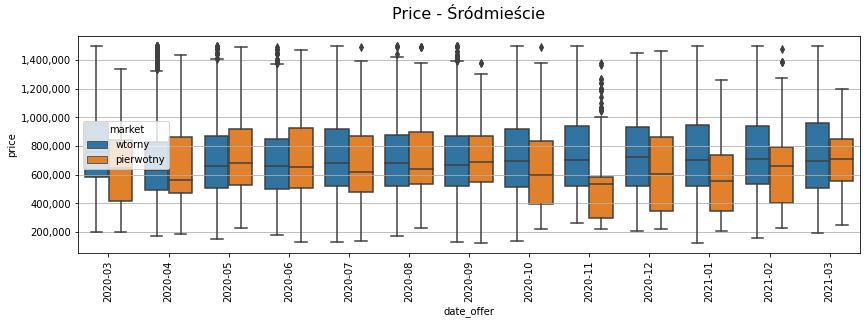

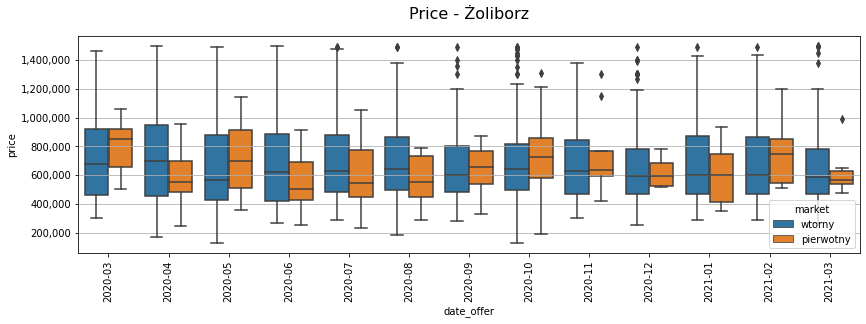

In [72]:
_tmp = pd.DataFrame(
    {'date_offer':df.date_offer.dt.to_period("M"),
     'price':df.price,
     'market':df.market,
     'GC_addr_suburb': df.GC_addr_suburb,
     'GC_addr_city':df.GC_addr_city,
     'flat_size':df.flat_size})
_tmp = _tmp.query("date_offer >= '2020-03' and price > 10e4 and price < 15e5 and flat_size < 250 and GC_addr_city=='Warszawa'").reset_index()

for m in sorted(_tmp.GC_addr_suburb.fillna('brak').unique()):

    if m != 'brak':
        fig, ax = plt.subplots(figsize=(14,4))
        sns.boxplot(x="date_offer",  y="price",hue='market', data=_tmp.query(f"GC_addr_suburb=='{m}'"), ax=ax, order=sorted(_tmp.date_offer.unique()))
        plt.xticks(rotation=90)
        plt.title(f'Price - {m}', y=1.05, fontsize = 16)
        ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:,.0f}'.format(y))) 
        ax.yaxis.grid(True)
        plt.show()
